This notebook contains the reproduction of the power curves in figure 2 of the paper "Discovering and Deciphering Relationships Across Disparate Data Modalities". Plots here include: 
* the difference between the power computed using ``mgcpy`` and the paper results, using data pre-generated with the matlab code in the github repository ``mgc-paper``
* partially completed power curves generated using ``mgcpy``

In [ ]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [2]:
import sys
module_path = '/Users/junhaoxiong 1/Documents/Projects/mgcpy'
if module_path not in sys.path:
    sys.path.append(module_path)
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power import power, power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
def find_dim(sim_name):
    dim = 0
    if sim_name in ['joint_normal', 'sine_4pi', 'sine_16pi', 'multi_noise']:
        dim = 10
    elif sim_name in ['step', 'spiral', 'circle', 'ellipse', 'quadratic', 'w_shape', 'two_parabolas', 'fourth_root']:
        dim = 20
    elif sim_name in ['multi_indept', 'bernoulli', 'log']:
        dim = 100
    elif sim_name in ['linear', 'exponential', 'cubic']:
        dim = 1000
    else:
        dim = 40
    return dim

In [4]:
simulations = {'joint_normal': (joint_sim, 4), 'sine_4pi': (sin_sim, 12), 'sine_16pi': (sin_sim, 13), 'multi_noise': (multi_noise_sim, 19),
               'step': (step_sim, 5), 'spiral': (spiral_sim, 8), 'circle': (circle_sim, 16), 'ellipse': (circle_sim, 17), 'diamond': (square_sim, 18),
               'log': (log_sim, 10), 'quadratic': (quad_sim, 6), 'w_shape': (w_sim, 7), 'two_parabolas': (two_parab_sim, 15), 'fourth_root': (root_sim, 11),
               'multi_indept': (multi_indep_sim, 20), 'bernoulli': (ubern_sim, 9), 'square': (square_sim, 14),
              'linear': (linear_sim, 1), 'exponential': (exp_sim, 2), 'cubic': (cub_sim, 3)}

In [5]:
def find_dim_range(dim):
    if dim < 20:
        lim = 10
    else:
        lim = 20
    
    dim_range = np.arange(math.ceil(dim/lim), dim+1, math.ceil(dim/lim))
    if math.ceil(dim/lim) != 1:
        dim_range= np.insert(dim_range, 0, 1)
        lim = dim_range.shape[0]
    return (lim, dim_range)

## Parallel code

In [6]:
def power_vs_dimension_parallel(params_dict):
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())

    dim = params_dict['dim']
    lim, dim_range = find_dim_range(dim)
    
    estimated_power = np.zeros(lim)
    
    for i in range(lim):
        estimated_power[i] = power_given_data(test, sim, num_samples=100, num_dimensions=dim_range[i])
    
    np.savetxt('../mgcpy/benchmarks/python_power_curves_dimensions/{}_{}_dimensions.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [7]:
def fill_params_dict_list_dimensions():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    rv_corr = RVCorr(which_test='rv')
    hhg = HHG()
    cca = RVCorr(which_test='cca')
    independence_tests = [mantel] #[mgc, mcorr, dcorr, mantel, rv_corr, cca] 
        
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1], 'dim': find_dim(sim_name)}
            params_dict_list.append(params_dict)
    return params_dict_list

In [8]:
def power_vs_sample_size_parallel(params_dict):
    sample_sizes = [i for i in range(5, 101, 5)]
    estimated_power = np.zeros(len(sample_sizes))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(sample_sizes)):
        estimated_power[i] = power_given_data(test, sim, data_type='sample_size', num_samples=sample_sizes[i], num_dimensions=1)
    
    np.savetxt('../mgcpy/benchmarks/python_power_curves_sample_size/{}_{}_sample_size.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [9]:
def fill_params_dict_list_sample_sizes():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    hhg = HHG()
    pearson = RVCorr(which_test='pearson')
    independence_tests = [mantel] #[mgc, mcorr, dcorr, mantel, pearson]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [17]:
params_dict = fill_params_dict_list_dimensions()

In [18]:
%%time
pool = mp.Pool(mp.cpu_count()-1)
#results = pool.map(power_vs_dimension_parallel, params_dict)
results = pool.map(power_vs_sample_size_parallel, params_dict)

13 mantel
5 mantel
4 mantel
4 mantel finished
5 mantel finished
12 mantel
8 mantel
13 mantel finished
19 mantel
8 mantel finished
16 mantel
19 mantel finished
18 mantel
12 mantel finished
6 mantel
16 mantel finished
17 mantel
18 mantel finished
10 mantel
6 mantel finished
7 mantel
17 mantel finished
15 mantel
10 mantel finished
20 mantel
7 mantel finished
14 mantel
15 mantel finished
11 mantel
14 mantel finished
1 mantel
20 mantel finished
9 mantel
11 mantel finished
2 mantel
1 mantel finished
9 mantel finished
2 mantel finished
3 mantel
3 mantel finished
CPU times: user 84.4 ms, sys: 57.5 ms, total: 142 ms
Wall time: 1min 33s


In [31]:
num = 5
python_power = np.genfromtxt('../mgcpy/benchmarks/python_power_curves_dimensions/{}_mantel_dimensions.csv'.format(num), delimiter=',')
matlab_power = scipy.io.loadmat('../mgcpy/benchmarks/matlab_power_results/dimension/CorrIndTestDimType{}N100Dim.mat'.format(num))['powerP'][0,:]
'''
python_power = np.genfromtxt('../mgcpy/benchmarks/python_power_curves_sample_size/{}_mantel_sample_size.csv'.format(num), delimiter=',')
with h5py.File('../mgcpy/benchmarks/matlab_power_results/sample_size/CorrIndTestType{}N100Dim1.mat'.format(num), 'r') as f:
    matlab_results = {}
    for k, v in f.items():
        matlab_results[k] = np.transpose(np.array(v))
matlab_power = matlab_results['powerP'][0,:]
'''

"\npython_power = np.genfromtxt('../mgcpy/benchmarks/python_power_curves_sample_size/{}_mantel_sample_size.csv'.format(num), delimiter=',')\nwith h5py.File('../mgcpy/benchmarks/matlab_power_results/sample_size/CorrIndTestType{}N100Dim1.mat'.format(num), 'r') as f:\n    matlab_results = {}\n    for k, v in f.items():\n        matlab_results[k] = np.transpose(np.array(v))\nmatlab_power = matlab_results['powerP'][0,:]\n"

In [32]:
python_power

array([1.   , 0.536, 0.405, 0.376, 0.313, 0.235, 0.226, 0.221, 0.182,
       0.151, 0.18 , 0.162, 0.163, 0.175, 0.139, 0.174, 0.112, 0.15 ,
       0.139, 0.157])

In [33]:
matlab_power

array([0.    , 0.5644, 0.4162, 0.3555, 0.2879, 0.2514, 0.2426, 0.2073,
       0.2119, 0.1945, 0.176 , 0.1799, 0.1674, 0.1588, 0.1578, 0.1547,
       0.1306, 0.1373, 0.1412, 0.1199])

In [25]:
def plot_diff_curves(which_type):
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
    dir_name = '../mgcpy/benchmarks/matlab_power_results/'
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            if which_type == 'dimension':
                tests = ['mgc', 'unbiased', 'biased', 'mantel', 'hhg', 'rv', 'cca']
                python_results_dir_name = '../mgcpy/benchmarks/python_power_curves_dimensions/'
                
                matlab_file_name = dir_name + 'dimension/CorrIndTestDimType{}N100Dim.mat'.format(simulation_type)
                # .mat files are in different versions and require different file readers
                if simulation_type in [1, 2, 13, 14, 15, 16]:
                    with h5py.File(matlab_file_name, 'r') as f:
                        matlab_results = {}
                        for k, v in f.items():
                            matlab_results[k] = np.transpose(np.array(v))
                else:
                    matlab_results = scipy.io.loadmat(matlab_file_name)
                        
                for test in tests:
                    python_power = np.genfromtxt(python_results_dir_name + '{}_{}_dimensions.csv'.format(simulation_type, test), delimiter=',')
                    _, dim_range = find_dim_range(find_dim(sim_name))
                    x_axis = dim_range
                    
                    # get the corresponding matlab result
                    matlab_str_code = ''
                    if test == 'mgc':
                        matlab_str_code = 'MGC'
                    elif test == 'unbiased':
                        matlab_str_code = 'M'
                    elif test == 'biased':
                        matlab_str_code = 'D'
                    elif test == 'mantel':
                        matlab_str_code = 'P'
                    elif test == 'hhg':
                        matlab_str_code = 'HHG'
                    elif test == 'rv':
                        matlab_str_code = 'Corr'
                    elif test == 'cca':
                        matlab_str_code = 'CCA'
                    matlab_power = matlab_results['power{}'.format(matlab_str_code)][0,:]
                    
                    col.plot(x_axis, python_power-matlab_power, label=test)
                    col.set_ylim(-1, 1)
                    #col.set_yticks([])
                    col.set_title(sim_name)
                    #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            elif which_type == 'sample_size':
                tests = ['mgc', 'unbiased', 'biased', 'mantel', 'hhg', 'pearson']
                python_results_dir_name = '../mgcpy/benchmarks/python_power_curves_sample_size/'
                
                matlab_file_name = dir_name + 'sample_size/CorrIndTestType{}N100Dim1.mat'.format(simulation_type)
                # .mat files are in different versions and require different file readers
                #if simulation_type in [1, 2, 13, 14, 15, 16]:
                with h5py.File(matlab_file_name, 'r') as f:
                    matlab_results = {}
                    for k, v in f.items():
                        matlab_results[k] = np.transpose(np.array(v))
                        
                for test in tests:
                    python_power = np.genfromtxt(python_results_dir_name + '{}_{}_sample_size.csv'.format(simulation_type, test), delimiter=',')
                    x_axis = [i for i in range(5, 101, 5)]
                    
                    # get the corresponding matlab result
                    matlab_str_code = ''
                    if test == 'mgc':
                        matlab_str_code = 'MGC'
                    elif test == 'unbiased':
                        matlab_str_code = 'M'
                    elif test == 'biased':
                        matlab_str_code = 'D'
                    elif test == 'mantel':
                        matlab_str_code = 'P'
                    elif test == 'hhg':
                        matlab_str_code = 'HHG'
                    elif test == 'pearson':
                        matlab_str_code = 'Corr'
                    matlab_power = matlab_results['power{}'.format(matlab_str_code)][0,:]
                    
                    col.plot(x_axis, python_power-matlab_power, label=test)
                    col.set_ylim(-1, 1)
                    #col.set_yticks([])
                    col.set_title(sim_name)
                    #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    if which_type == 'dimension':
        fig.suptitle('Difference between Python and Matlab Implemention (Python minus Matlab) of Power with Increasing Dimensions')
        plt.savefig('../../../../Desktop/Neuro Data Design/diff_power_dimensions.png')
    else:
        fig.suptitle('Difference between Python and Matlab Implemention (Python minus Matlab) of Power with Increasing Sample Size')
        plt.savefig('../../../../Desktop/Neuro Data Design/diff_power_sample_size.png')

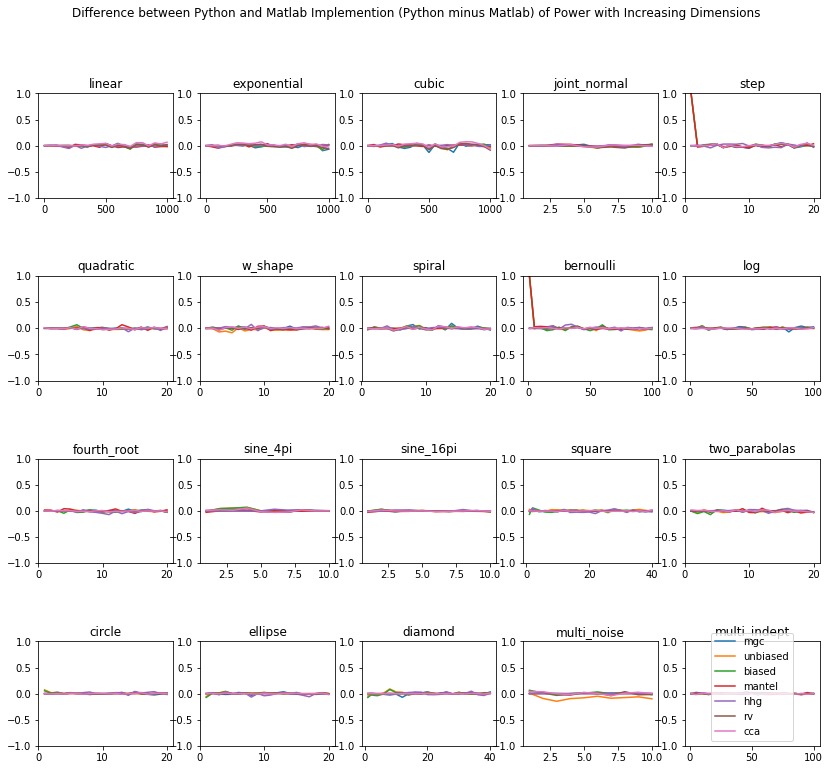

In [27]:
plot_diff_curves('dimension')

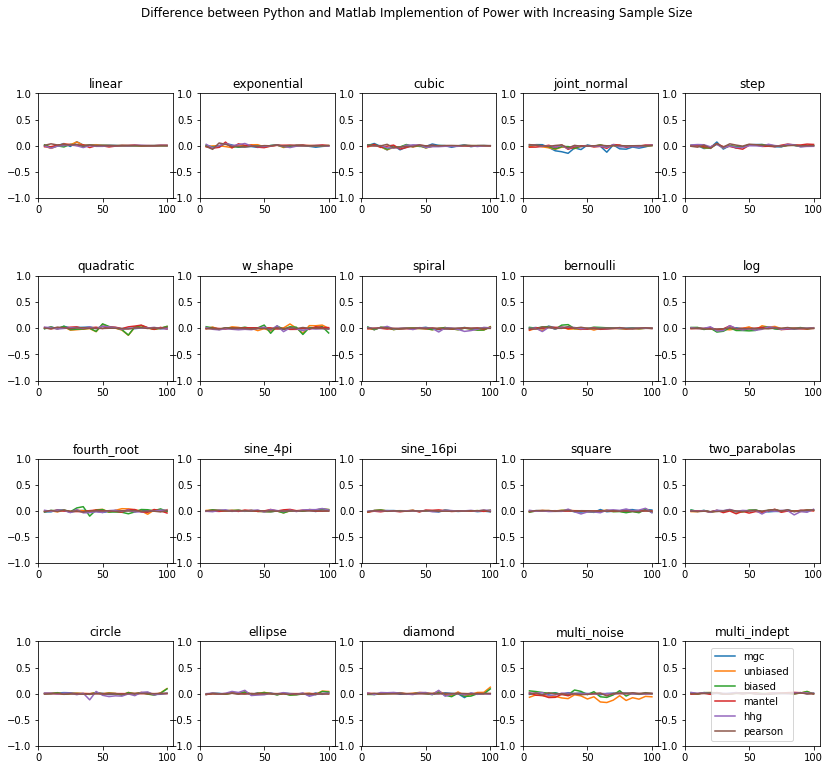

In [24]:
plot_diff_curves('sample_size')

In [12]:
def plot_all_curves(which_type):
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12))  
    simulation_type = 0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            if which_type == 'dimension':
                tests = ['mgc', 'mcorr', 'dcorr', 'mantel', 'rv', 'cca']
                dir_name = '../mgcpy/benchmarks/power_curves_dimensions/'
                if simulation_type == 1 or simulation_type == 2 or simulation_type == 3:
                #(i == 0 and (j == 0 or j == 1 or j == 2)) or (i == 1 and j == 3):
                    col.set_ylim(-1, 1)
                    col.set_yticks([])
                    col.set_title(sim_name)
                    continue
                file = open(dir_name + '{}_mgc_dimensions.pkl'.format(simulation_type), 'rb')
                mgc_power = pickle.load(file)
                file.close()

                for test in tests:
                    file = open(dir_name + '{}_{}_dimensions.pkl'.format(simulation_type, test), 'rb')
                    power = pickle.load(file)
                    file.close()
                    x_axis = np.arange(1, mgc_power.shape[0]+1)
                    col.plot(x_axis, power-mgc_power, label=test)
                    col.set_ylim(-1, 1)
                    col.set_yticks([])
                    col.set_title(sim_name)
                    #file = open('../../NeuroData/power_curve_{}.pkl'.format(sim_name),  'rb')
            else:
                tests = ['mgc', 'mcorr', 'dcorr', 'mantel', 'pearson']
                dir_name = '../mgcpy/benchmarks/power_curves_sample_sizes/'
                file = open(dir_name + '{}_mgc_sample_size.pkl'.format(simulation_type), 'rb')
                mgc_power = pickle.load(file)
                file.close()

                for test in tests:
                    file = open(dir_name + '{}_{}_sample_size.pkl'.format(simulation_type, test), 'rb')
                    power = pickle.load(file)
                    file.close()
                    x_axis = [i for i in range(5, 101, 5)]
                    col.plot(x_axis, power-mgc_power, label=test)
                    col.set_ylim(-1, 1)
                    col.set_yticks([])
                    col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    if which_type == 'dimension':
        fig.suptitle('Power Relative to MGC of Increasing Dimensions')
        plt.savefig('../../../../Desktop/Neuro Data Design/all_curves_dimensions')
    else:
        fig.suptitle('Power Relative to MGC of for 20 Simulated 1-Dimensional Settings')
        plt.savefig('../../../../Desktop/Neuro Data Design/all_curves_sample_size')

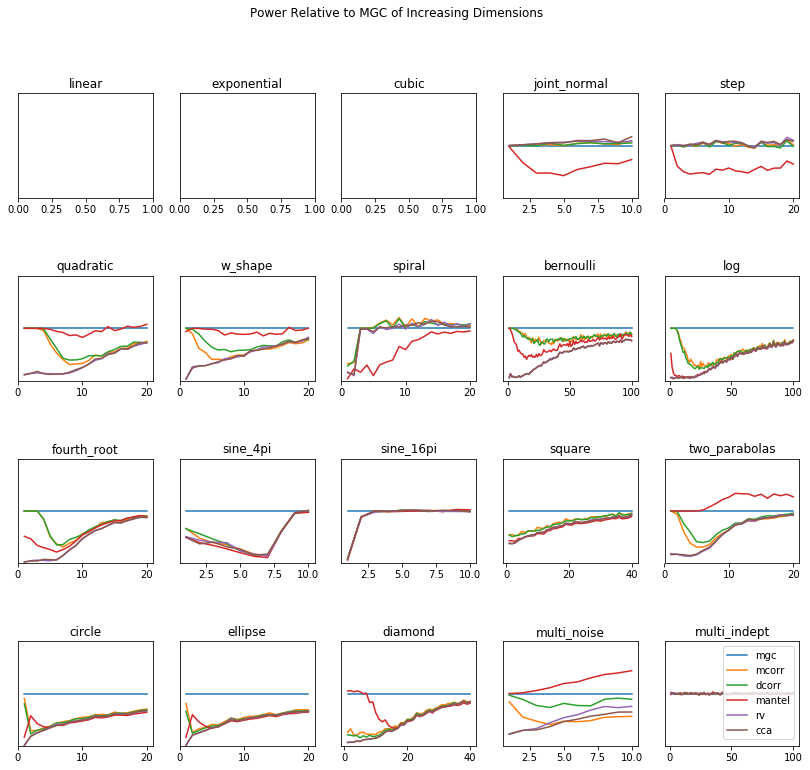

In [14]:
plot_all_curves('dimension')

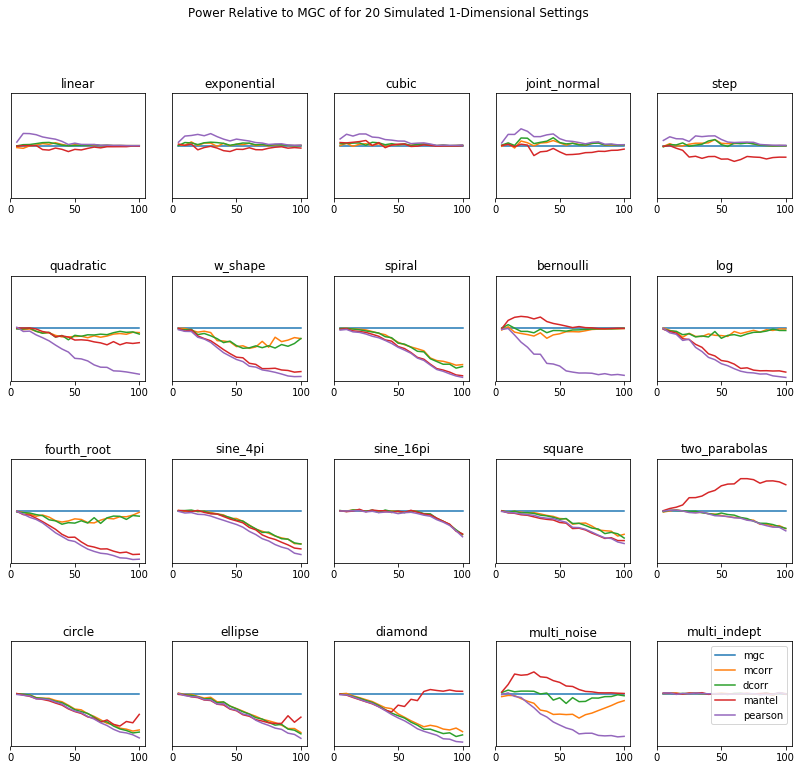

In [13]:
plot_all_curves('sample_sizes')